# Exercises on Enhancement

Part of these exercises are from the book "A Primer on Process Mining", by Diogo Ferreira.

In [0]:
# ==============================================================================
# read the log
from dateutil.parser import parse
import xml.etree.ElementTree as ET

tree = ET.parse('extension-log.xes')
root = tree.getroot()

ns = {'xes': 'http://www.xes-standard.org/'}

log = dict()
for trace in root.findall('xes:trace', ns):
  caseid = trace.find('xes:string[@key="concept:name"]', ns).attrib['value']
  log[caseid] = []
  for event in trace.findall('xes:event', ns):
    e = dict()
    # collect all attributes and properly cast them to Python type
    for attribute in event.findall('xes:string', ns):
      e[attribute.attrib['key']] = attribute.attrib['value']
    for attribute in event.findall('xes:int', ns):
      e[attribute.attrib['key']] = int(attribute.attrib['value'])
    for attribute in event.findall('xes:date', ns):
      e[attribute.attrib['key']] = parse(attribute.attrib['value'])
    for attribute in event.findall('xes:boolean', ns):
      e[attribute.attrib['key']] = attribute.attrib['value'] == 'true'
    # append the event to the proper case
    log[caseid].append(e)

In [0]:
# ==============================================================================
# construct the dependency

F = dict()
for caseid in log:
  for i in range(0, len(log[caseid])-1):
    ai = log[caseid][i]['concept:name']
    aj = log[caseid][i+1]['concept:name']
    if ai not in F:
      F[ai] = dict()
    if aj not in F[ai]:
      F[ai][aj] = 0
    F[ai][aj] += 1

# print the dependency matrix
# for ai in sorted(F.keys()):
#   for aj in sorted(F[ai].keys()):
#     print (ai, '->', aj, ':', F[ai][aj])


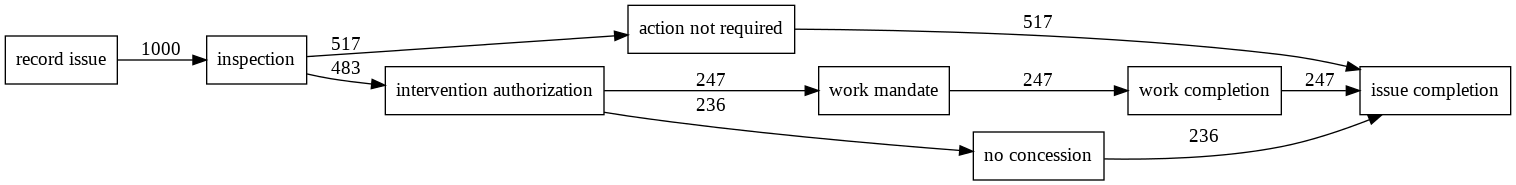

In [21]:
# ==============================================================================
# generate the graphical output

#!apt-get -qq install -y graphviz libgraphviz-dev pkg-config && pip install pygraphviz;

import pygraphviz as pgv
from IPython.display import Image

G = pgv.AGraph(strict=False, directed=True)

G.graph_attr['rankdir'] = 'LR'
G.node_attr['shape'] = 'box'

for ai in F:
  for aj in F[ai]:
    G.add_edge(ai, aj, label=F[ai][aj])

G.draw('graph.png', prog='dot')
Image(filename="graph.png")


In [0]:
# ==============================================================================
# identify all splits

splits = dict()

for node in G.nodes():
  if len(G.out_neighbors(node)) > 1:
    splits[node] = G.out_neighbors(node)


In [0]:
# ==============================================================================
# extraction of data points for all splits

# definition of the classification data
splits_headers = dict()
splits_data = dict()
splits_labels = dict()

# initialize the classification data
for split in splits:
  splits_data[split] = []
  splits_labels[split] = []

# filling of classification data
for caseid in log:
  for i in range(0, len(log[caseid])-1):
    activity = log[caseid][i]['concept:name']
    if activity in splits:
      if not activity in splits_headers:
        splits_headers[activity] = list(log[caseid][i].keys())
        splits_headers[activity].remove("time:timestamp")

      splits_data[activity].append([log[caseid][i][a] for a in splits_headers[activity]])
      splits_labels[activity].append(log[caseid][i+1]['concept:name'])

# print(splits_data['intervention authorization'])
# print(splits_labels['intervention authorization'])

In [0]:
import re

def extract_condition(decision_tree, target_class, feature_names=None):
  text = export_text(decision_tree.tree_, feature_names)
  p = re.compile("(.*): "+ target_class +" \(\d+\)")
  for line in text.splitlines():
    m = p.match(line)
    if m:
      return m.group(1)

In [0]:
# ==============================================================================
# decision mininig problem

#!pip install decision-tree-id3
from id3 import Id3Estimator, export_text

conditions = dict()

for split in splits:
  tree = Id3Estimator()
  tree.fit(splits_data[split], splits_labels[split], check_input=True)
  conditions[split] = dict()
  for branch in splits[split]:
    cond = extract_condition(tree, branch, splits_headers[split])
    conditions[split][branch] = cond

#print(conditions)

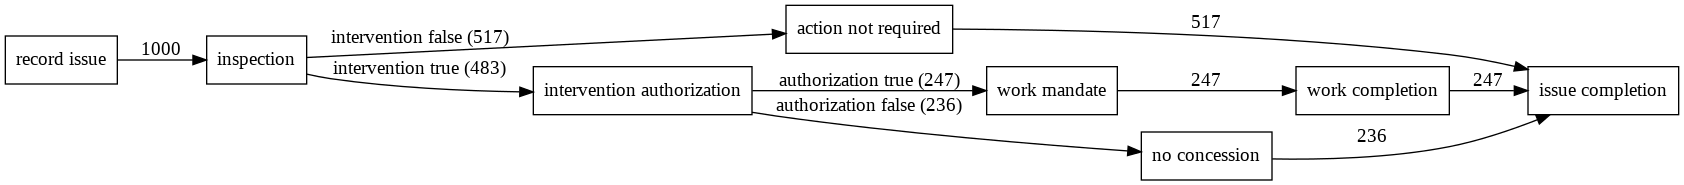

In [13]:
# ==============================================================================
# generate the new graphical output with conditions

G = pgv.AGraph(strict=False, directed=True)

G.graph_attr['rankdir'] = 'LR'
G.node_attr['shape'] = 'box'

for ai in F:
  for aj in F[ai]:
    if (ai in conditions) and (aj in conditions[ai]):
      G.add_edge(ai, aj, label= conditions[ai][aj] + " (" + str(F[ai][aj]) + ")")
    else:
      G.add_edge(ai, aj, label=F[ai][aj])

G.draw('graph.png', prog='dot')
Image(filename="graph.png")


In [0]:
# ==============================================================================
# extension of the model with all costs

normalized_costs = dict()
costs = dict()
for trace in log:
  for event in log[trace]:
    activity = event['concept:name']
    cost = event['cost']
    if activity in costs:
      costs[activity] += cost
    else:
      costs[activity] = cost

# normalize costs
max_cost = max(set(costs.values()))
for act in costs:
  normalized_costs[act] = costs[act] / max_cost

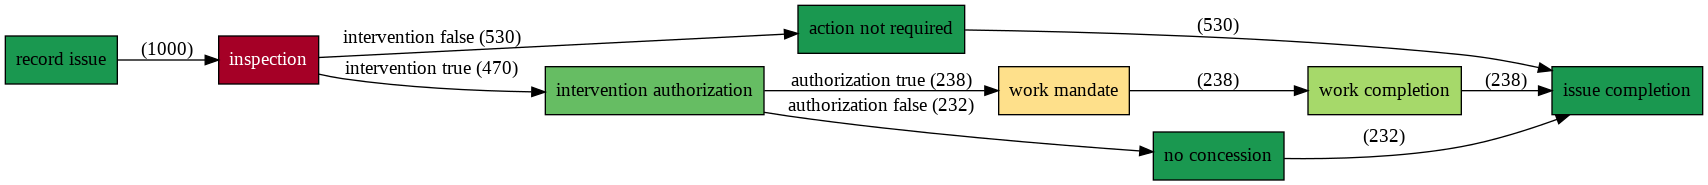

In [66]:
# ==============================================================================
# generate the new graphical output with conditions and costs color

G = pgv.AGraph(strict=False, directed=True)

G.graph_attr['rankdir'] = 'LR'
G.node_attr['shape'] = 'box'

for act in costs:
  color = str(int((1 - normalized_costs[act]) * 10) + 1)
  font = "black"
  if costs[act] < .3 or normalized_costs[act] > .7:
    font = "white"
  G.add_node(act, style="filled", fillcolor=color, colorscheme = "rdylgn11", fontcolor=font)

for ai in F:
  for aj in F[ai]:
    if (ai in conditions) and (aj in conditions[ai]):
      G.add_edge(ai, aj, label= conditions[ai][aj] + " (" + str(F[ai][aj]) + ")")
    else:
      G.add_edge(ai, aj, label="(" + str(F[ai][aj]) + ")")

G.draw('graph.png', prog='dot')
Image(filename="graph.png")